In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, mean_squared_error
from sklearn.model_selection import learning_curve

from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading in the dataset and inspecting the first few rows
df = pd.read_csv('cleaned_titanic_df.txt')
df.head()

,Unnamed: 0,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,...,title,male,cabin_deck,Embarked_s,Embarked_q,Embarked_c,family_size,is_alone,is_child,is_senior
0,0,1,0,3,male,22.0,1,0,7.2500,NaN,...,Mr,1,6,1,0,0,2,0,0,0
1,1,2,1,1,female,38.0,1,0,71.2833,C85,...,Mrs,0,3,0,0,1,2,0,0,0
2,2,3,1,3,female,26.0,0,0,7.9250,NaN,...,Miss,0,6,1,0,0,1,1,0,0
3,3,4,1,1,female,35.0,1,0,53.1000,C123,...,Mrs,0,3,1,0,0,2,0,0,0
4,4,5,0,3,male,35.0,0,0,8.0500,NaN,...,Mr,1,6,1,0,0,1,1,0,0


In [3]:
# Removing unwanted columns
df = df.drop(columns=['Unnamed: 0', 'Pclass', 'Sex', 'Cabin', 'Embarked'])

# Checking Logistic Regression Assumptions

In [4]:
# Checking that all observations are independent
df.PassengerId.nunique() == df.PassengerId.count()

True

In [5]:
# Checking how many rows of data and how many features
df.shape
# 871 rows of data is enough for features using the rule of 10 samples for each feature

(871, 19)

In [6]:
# Checking the outcome variable to see how balanced it is
df.Survived.value_counts()

Survived
0    543
1    328
Name: count, dtype: int64

In [7]:
# Checking the Positivity Rate to see how balanced the outcome variable is percentage wise
positivity_rate = 328/len(df)
print(positivity_rate)
# We can see that the positivity rate is not balanced, so this will be addressed with oversampling

0.37657864523536166


In [8]:
# Creating a dummy df to turn categorical columns into numeric
dummy_df = pd.get_dummies(df, columns=['title'], drop_first=False, dtype='int64')

In [9]:
# Creating two new variable, one for the features and one for the outcome 
x = dummy_df.drop(columns=['PassengerId', 'Survived'])
y = dummy_df[['Survived']]

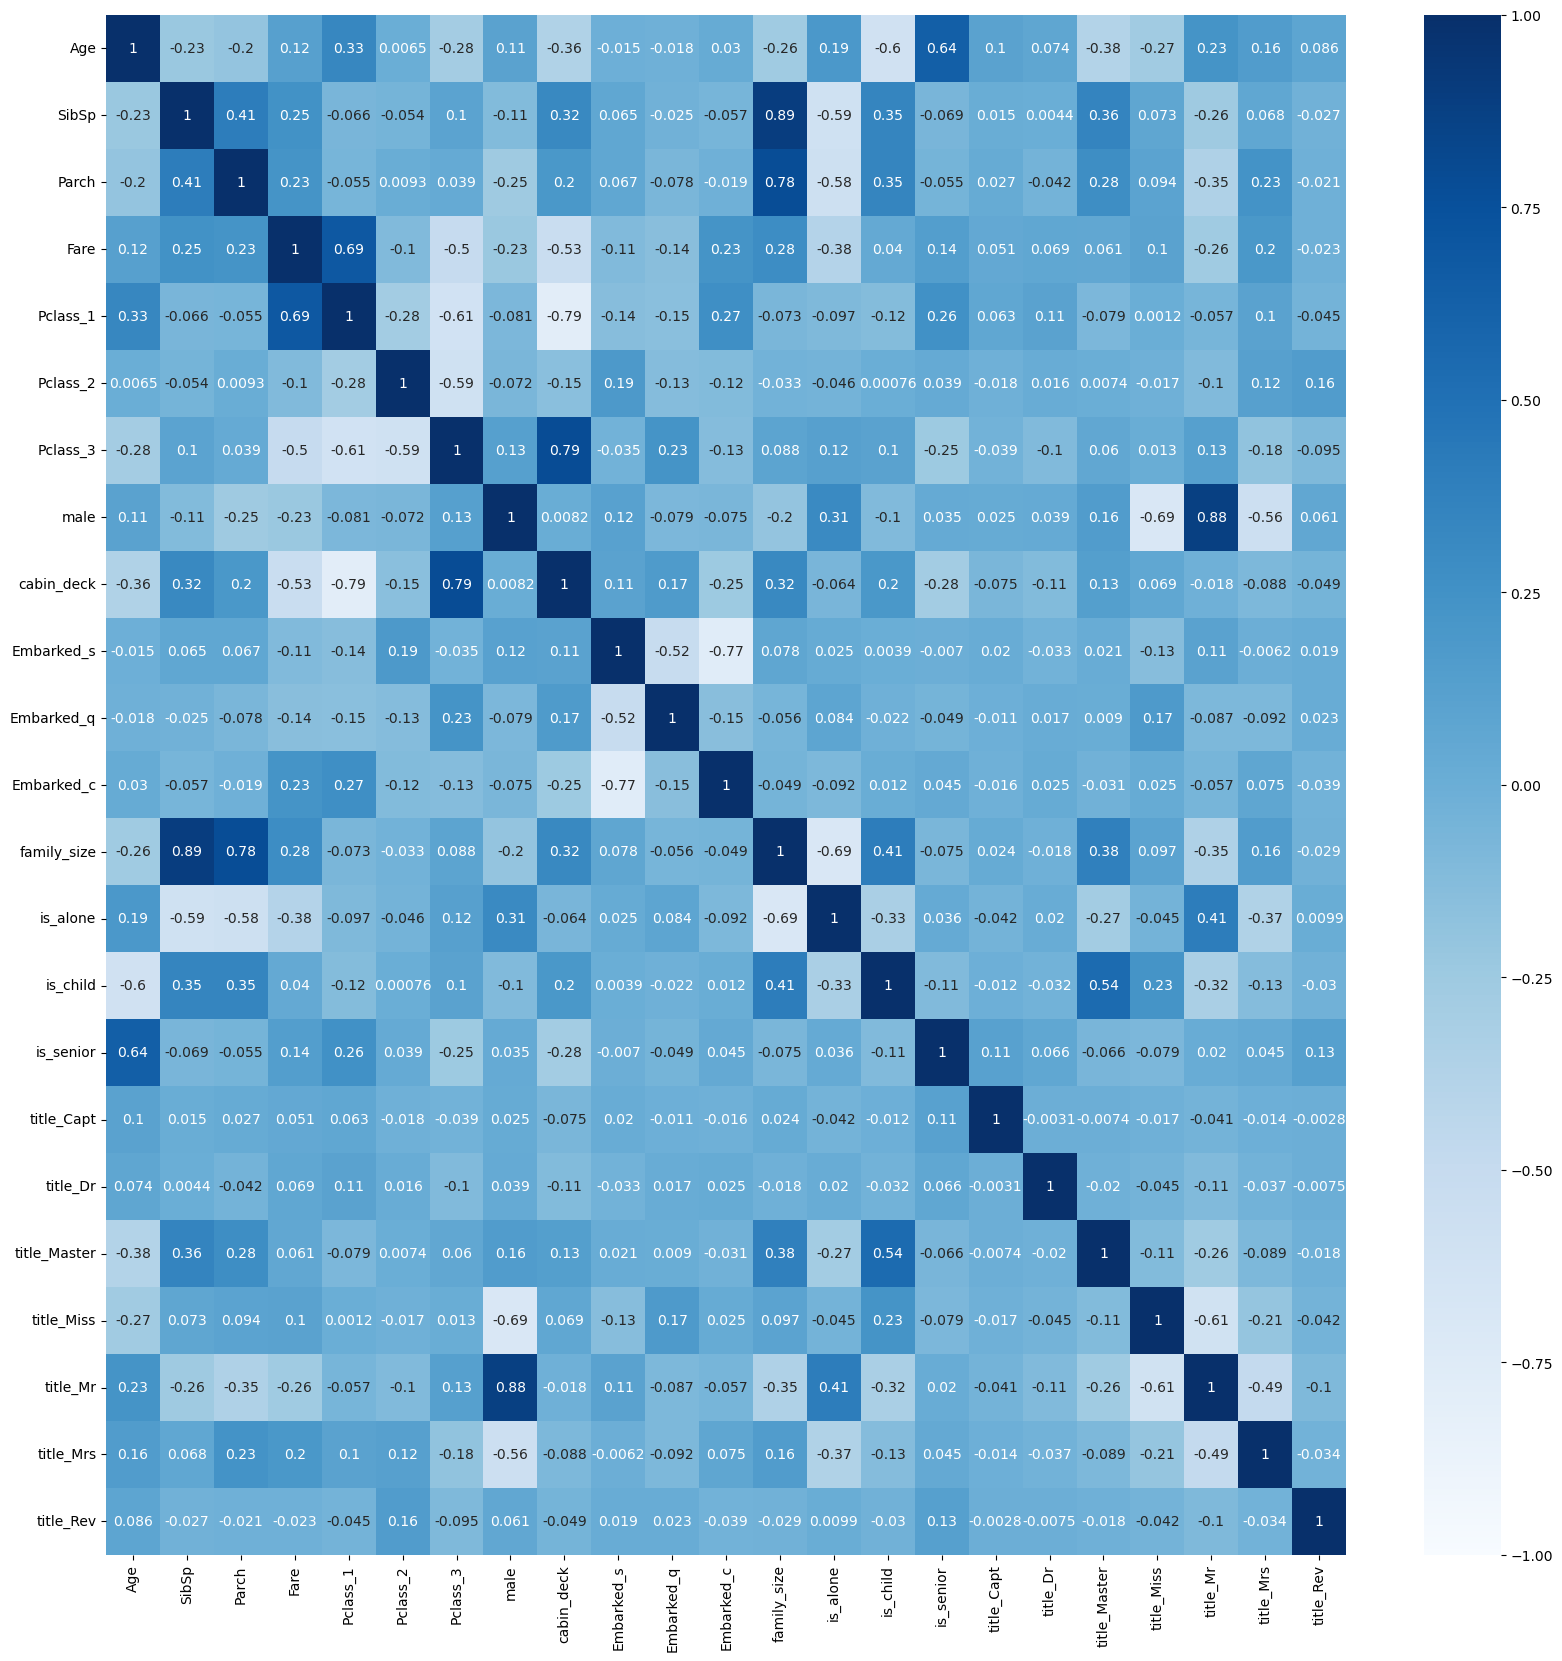

In [10]:
# Visualising the correlation between each feature
plt.figure(figsize=(20,20))
sns.heatmap(x.corr(), annot=True, vmin=-1, center=0, vmax=1, cmap='Blues')
plt.show()

In [11]:
# Removing columns with high correlation
x = x.drop(columns=['family_size', 'title_Mr', 'cabin_deck', 'Embarked_c'])

# Best Train Test Split

In [12]:
# Function to train and evaluate a logistic regression model on different train/test/split random states
def best_random_state(state):
    
    # Train Test Split
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=state)   
    
    # Applying SMOTE to balance the training set
    sm = SMOTE(random_state=1, sampling_strategy= 'minority')
    x_train_res, y_train_res = sm.fit_resample(x_train, y_train)
    
    # Scaling the training and testing sets
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train_res)
    x_test_scaled = scaler.transform(x_test)
    
    # Initialize and train the logistic regression model
    model = LogisticRegression(random_state=1, n_jobs=-1)
    model.fit(x_train_scaled, y_train_res)
    
    # Evaluate the model and return the accuracy
    accuracy = model.score(x_test_scaled, y_test)
    return accuracy

In [13]:
# Creating an empty list to hold all the accuracies from different random states
acc = []

# Performing the function for 100 different random states and adding the accuracies to the list
for k in range(1,101):
    acc.append(best_random_state(k))

In [14]:
# Creating a list of the random state potential numbers
random_state_list = range(1,101)

# Finding the index of the max value in the list
best_split_index = acc.index(max(acc))

# Using the index to find the best train test split
best_split = random_state_list[best_split_index]
best_split

83

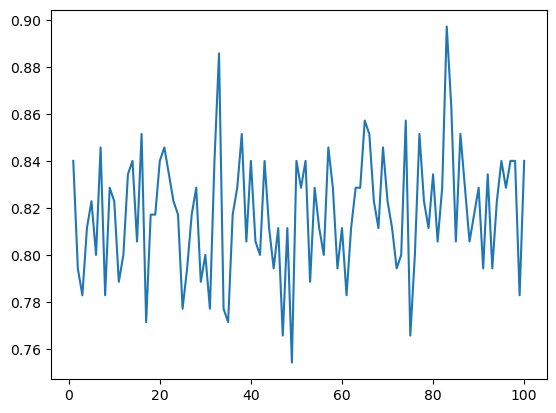

In [15]:
# Visualising the test scores associated with each random state value
plt.plot(random_state_list, acc)
plt.show()

# Best SMOTE Random State

In [16]:
# Function to train and evaluate a logistic regression model for best smote random state
def best_smote_random_state(state):
    
    # Train Test Split
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=best_split)   
    
    # Applying SMOTE to balance the training set
    sm = SMOTE(random_state=state, sampling_strategy= 'minority')
    x_train_res, y_train_res = sm.fit_resample(x_train, y_train)
    
    # Scaling the training and testing sets
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train_res)
    x_test_scaled = scaler.transform(x_test)
    
    # Initialize and train the logistic regression model
    model = LogisticRegression(random_state=1, n_jobs=-1)
    model.fit(x_train_scaled, y_train_res)
    
    # Evaluate the model and return the accuracy
    accuracy = model.score(x_test_scaled, y_test)
    return accuracy

In [17]:
# Creating an empty list to hold all the accuracies from different smote random states
smote_acc = []

# Performing the function for 100 different random states and adding the accuracies to the list
for k in range(1,101):
    smote_acc.append(best_smote_random_state(k))

In [18]:
# Finding the index of the max value in the list
best_smote_split_index = smote_acc.index(max(smote_acc))

# Using the index to find the best train test split
best_smote_split = random_state_list[best_smote_split_index]
best_smote_split

2

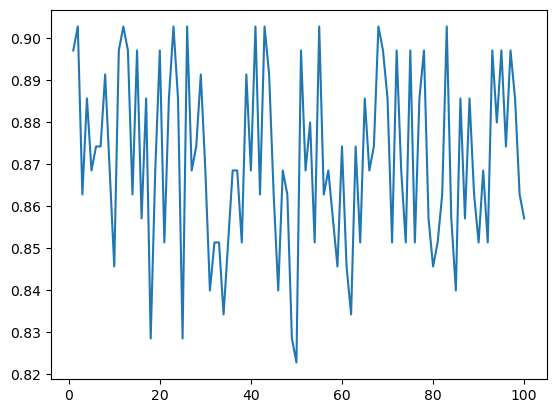

In [19]:
# Visualising the test scores associated with each random state value
plt.plot(random_state_list, smote_acc)
plt.show()

# Train Test Split

In [20]:
# Splitting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=best_split)    

# SMOTE

In [21]:
# Checking the value counts for the outcome variable in the training data
print(y_train.value_counts())

Survived
0           435
1           261
Name: count, dtype: int64


In [22]:
# Balancing out the outcome variable 'survived' in the training data using SMOTE
sm = SMOTE(random_state=best_smote_split, sampling_strategy='minority')

# Applying the smote sampler to the training data
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)

# Checking the value counts for the outcome variable in the training data
print(y_train_res.value_counts())

Survived
0           435
1           435
Name: count, dtype: int64


# Scaling 

In [23]:
# Creating a standard scaler model 
scaler = StandardScaler()

# Fitting the model to the training data and transforming it
x_train_scaled = scaler.fit_transform(x_train_res)

# Transforming the testing data
x_test_scaled = scaler.transform(x_test)

# Logistic Regression Model

In [24]:
# Creating a logistic regression model
model = LogisticRegression(random_state=1, n_jobs=-1)

# Fitting the model to the training data
model.fit(x_train_scaled, y_train_res)

LogisticRegression(n_jobs=-1, random_state=1)

# Evaluating Model

In [25]:
# Checking the accuracy score of the model on the training and test data
print('Train score')
print(model.score(x_train_scaled, y_train_res))
print('Test score')
print(model.score(x_test_scaled, y_test))

Train score
0.8229885057471265
Test score
0.9028571428571428


In [26]:
# Getting the prediction on the training and test data
y_pred_train = model.predict(x_train_scaled)
y_pred_test = model.predict(x_test_scaled)

In [27]:
# Getting the accuracy score of the model on the testing data
accuracy = accuracy_score(y_test, y_pred_test)
print('Accuracy score is ' + str(accuracy))

# Getting the precision score of the model on the testing data
precision = precision_score(y_test, y_pred_test)
print('Precision score is ' + str(precision))

# Getting the recall score of the model on the testing data
recall = recall_score(y_test, y_pred_test)
print('Recall score is ' + str(recall))

# Getting the f1 score of the model on the testing data
f1 = f1_score(y_test, y_pred_test)
print('F1 score is ' + str(f1))

Accuracy score is 0.9028571428571428
Precision score is 0.8787878787878788
Recall score is 0.8656716417910447
F1 score is 0.8721804511278195


In [28]:
# Getting the train and test mse
train_mse = mean_squared_error(y_train_res, y_pred_train)
print('Train MSE '+ str(train_mse))
test_mse = mean_squared_error(y_test, y_pred_test)
print('Test MSE ' + str(test_mse))

Train MSE 0.17701149425287357
Test MSE 0.09714285714285714


In [29]:
# Creating a confusion matrix to show the TN, FP, FN , TP
test_confusion_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred_test), index=['Died', 'Survived'], 
                                     columns=['Predicted Died', 'Predicted Survived'])
test_confusion_matrix

,Predicted Died,Predicted Survived
Died,100,8
Survived,9,58


# Feature selection 

In [30]:
# Using sequential forward floating feature selection, to see if we can reduce the number of features
sffs = SFS(model, k_features=19, forward=True, floating=True, scoring='accuracy', cv=5, n_jobs=-1)
# Fitting the the sffs to the training data
sffs = sffs.fit(x_train_scaled, y_train_res)

In [31]:
# Seeing the cv score using all 19 features
print(sffs.subsets_[19]['avg_score'])

0.8091954022988507


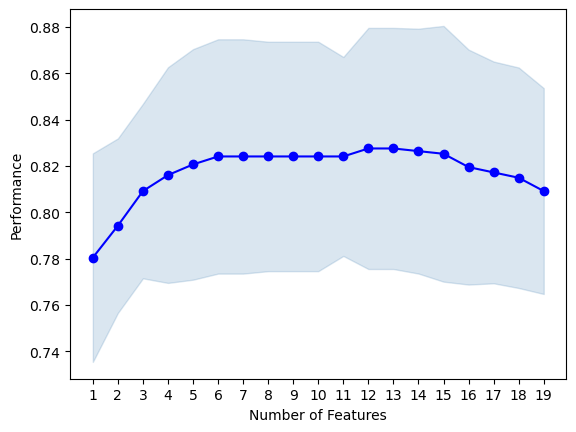

In [32]:
# Plotting the accuracy of the model as the number of features changes
plot_sfs(sffs.get_metric_dict())
plt.show()

In [33]:
# Using sequential forward floating feature selection to reduce the features down to 12
sffs_2 = SFS(model, k_features=12, forward=True, floating=True, scoring='accuracy', cv=5, n_jobs=-1)
# Fitting the sffs to the training data
sffs_2 = sffs_2.fit(x_train_scaled, y_train_res)

In [34]:
# Seeing the features that were selected
selected_features = sffs_2.k_feature_idx_
selected_feature_names = [x.columns[i] for i in selected_features]

print(sffs_2.k_feature_idx_)
print(selected_feature_names)
print(sffs_2.subsets_[12]['avg_score'])

(0, 1, 2, 6, 7, 9, 11, 13, 14, 15, 16, 18)
['Age', 'SibSp', 'Parch', 'Pclass_3', 'male', 'Embarked_q', 'is_child', 'title_Capt', 'title_Dr', 'title_Master', 'title_Miss', 'title_Rev']
0.8241379310344827


In [35]:
# Transforming the x_train_res and x_test data to just include the features selected
x_train_trans = sffs_2.transform(x_train_res)
x_test_trans = sffs_2.transform(x_test)

# Scaling

In [36]:
# Creating a new standard scaler model
scaler_2 = StandardScaler()

# Fitting the scaler and transforming the training data
x_train_scaled_2 = scaler_2.fit_transform(x_train_trans)

# Transforming the testing data
x_test_scaled_2 = scaler_2.transform(x_test_trans)

# Logistic Regression Model #2

In [37]:
# Creating a logistic regression model #2
model_2 = LogisticRegression(random_state=1, n_jobs=-1)

# Fitting the model to the training data
model_2.fit(x_train_scaled_2, y_train_res)

LogisticRegression(n_jobs=-1, random_state=1)

In [38]:
# Checking the accuracy score of the model #2 on the training and test data
print('Train score')
print(model_2.score(x_train_scaled_2, y_train_res))
print('Test score')
print(model_2.score(x_test_scaled_2, y_test))

Train score
0.8264367816091954
Test score
0.8914285714285715


In [39]:
# Getting the prediction on the training and test data
y_pred_train_2 = model_2.predict(x_train_scaled_2)
y_pred_test_2 = model_2.predict(x_test_scaled_2)

In [40]:
# Getting the accuracy score of the model on the testing data
accuracy_2 = accuracy_score(y_test, y_pred_test_2)
print('Accuracy score is ' + str(accuracy_2))

# Getting the precision score of the model on the testing data
precision_2 = precision_score(y_test, y_pred_test_2)
print('Precision score is ' + str(precision_2))

# Getting the recall score of the model on the testing data
recall_2 = recall_score(y_test, y_pred_test_2)
print('Recall score is ' + str(recall_2))

# Getting the f1 score of the model on the testing data
f1_2 = f1_score(y_test, y_pred_test_2)
print('F1 score is ' + str(f1_2))

Accuracy score is 0.8914285714285715
Precision score is 0.9
Recall score is 0.8059701492537313
F1 score is 0.8503937007874016


In [41]:
# Getting the train and test mse
train_mse_2 = mean_squared_error(y_train_res, y_pred_train_2)
print('Train MSE '+ str(train_mse_2))
test_mse_2 = mean_squared_error(y_test, y_pred_test_2)
print('Test MSE ' + str(test_mse_2))

Train MSE 0.1735632183908046
Test MSE 0.10857142857142857


In [42]:
# Creating a confusion matrix to show the TN, FP, FN , TP
test_confusion_matrix_2 = pd.DataFrame(confusion_matrix(y_test, y_pred_test_2), index=['Died', 'Survived'], 
                                     columns=['Predicted Died', 'Predicted Survived'])
test_confusion_matrix_2

,Predicted Died,Predicted Survived
Died,102,6
Survived,13,54


# Hyperparameter Tuning

In [43]:
# Creating an array of different C values for the grid search to try
c_array = np.logspace(-3, 3, 100)

# Putting the hyperparameters to tune into a dictionary
tuned_parameters = [{'penalty':['l1', 'l2'], 'C':c_array, 'solver':['newton-cg', 'lbfgs', 'liblinear']}]

# Creating a grid searchcv model to find the best combinations of hyperparameters
grid_model = GridSearchCV(model_2, param_grid=tuned_parameters, cv=10, scoring='accuracy', n_jobs=-1, verbose=1)

# Fitting the gridsearchcv to the training data
grid_model.fit(x_train_scaled_2, y_train_res)

Fitting 10 folds for each of 600 candidates, totalling 6000 fits


GridSearchCV(cv=10, estimator=LogisticRegression(n_jobs=-1, random_state=1),
             n_jobs=-1,
             param_grid=[{'C': array([1.00000000e-03, 1.14975700e-03, 1.32194115e-03, 1.51991108e-03,
       1.74752840e-03, 2.00923300e-03, 2.31012970e-03, 2.65608778e-03,
       3.05385551e-03, 3.51119173e-03, 4.03701726e-03, 4.64158883e-03,
       5.33669923e-03, 6.13590727e-03, 7.05480231e-03, 8.11130831e-03,
       9....
       7.05480231e+01, 8.11130831e+01, 9.32603347e+01, 1.07226722e+02,
       1.23284674e+02, 1.41747416e+02, 1.62975083e+02, 1.87381742e+02,
       2.15443469e+02, 2.47707636e+02, 2.84803587e+02, 3.27454916e+02,
       3.76493581e+02, 4.32876128e+02, 4.97702356e+02, 5.72236766e+02,
       6.57933225e+02, 7.56463328e+02, 8.69749003e+02, 1.00000000e+03]),
                          'penalty': ['l1', 'l2'],
                          'solver': ['newton-cg', 'lbfgs', 'liblinear']}],
             scoring='accuracy', verbose=1)

In [44]:
# Checking the best combinations of hyperparameters
print(grid_model.best_params_)
# Checking the score that these hyperparameters produced on the training data after cross validation
print(grid_model.best_score_)

{'C': 0.11497569953977356, 'penalty': 'l1', 'solver': 'liblinear'}
0.8264367816091955


# Tuned Logistic Regression Model

In [45]:
# Creating a tuned logistic regression model with the better hyperparameters
tuned_model = LogisticRegression(penalty=grid_model.best_params_['penalty'], 
                                 C=grid_model.best_params_['C'], 
                                 solver=grid_model.best_params_['solver'], 
                                 random_state=1, n_jobs=-1)

# Fitting the tuned model to the training data
tuned_model.fit(x_train_scaled_2, y_train_res)

LogisticRegression(C=0.11497569953977356, n_jobs=-1, penalty='l1',
                   random_state=1, solver='liblinear')

# Evaluating Tuned Model

In [46]:
# Checking the accuracy score on the training data
print('Train score')
print(tuned_model.score(x_train_scaled_2, y_train_res))
# Checking the accuracy score on the testing data
print('Test score')
print(tuned_model.score(x_test_scaled_2, y_test))

Train score
0.828735632183908
Test score
0.8971428571428571


In [47]:
# Getting the predictions on the training and testing data from the tuned model
y_pred_train_tuned = tuned_model.predict(x_train_scaled_2)
y_pred_test_tuned = tuned_model.predict(x_test_scaled_2)

In [48]:
# Getting the accuracy score of the tuned model on the testing data
accuracy_3 = accuracy_score(y_test, y_pred_test_tuned)
print('Accuracy score is ' + str(accuracy_3))

# Getting the precision score of the tuned model on the testing data
precision_3 = precision_score(y_test, y_pred_test_tuned)
print('Precision score is ' + str(precision_3))

# Getting the recall score of the tuned model on the testing data
recall_3 = recall_score(y_test, y_pred_test_tuned)
print('Recall score is ' + str(recall_3))

# Getting the f1 score of the tuned model on the testing data
f1_3 = f1_score(y_test, y_pred_test_tuned)
print('F1 score is ' + str(f1_3))

Accuracy score is 0.8971428571428571
Precision score is 0.9016393442622951
Recall score is 0.8208955223880597
F1 score is 0.859375


In [49]:
# Getting the train and test mse for the tuned model
train_mse_3 = mean_squared_error(y_train_res, y_pred_train_tuned)
print('Train MSE '+ str(train_mse_3))
test_mse_3 = mean_squared_error(y_test, y_pred_test_tuned)
print('Test MSE ' + str(test_mse_3))

Train MSE 0.17126436781609194
Test MSE 0.10285714285714286


In [50]:
# Creating a confusion matrix to show the TN, FP, FN , TP
test_confusion_matrix_3 = pd.DataFrame(confusion_matrix(y_test, y_pred_test_tuned), index=['Died', 'Survived'], 
                                     columns=['Predicted Dead', 'Predicted Survived'])
test_confusion_matrix_3

,Predicted Dead,Predicted Survived
Died,102,6
Survived,12,55


In [51]:
# Checking the coefficients for each feature
coefs = pd.DataFrame(zip(selected_feature_names, tuned_model.coef_[0]), columns=['Feature', 'Coef'])
coefs

,Feature,Coef
0,Age,-0.132271
1,SibSp,-0.439961
2,Parch,-0.247339
3,Pclass_3,-0.572763
4,male,-1.550202
5,Embarked_q,0.000000
6,is_child,0.065337
7,title_Capt,0.000000
8,title_Dr,0.000000
9,title_Master,0.517199


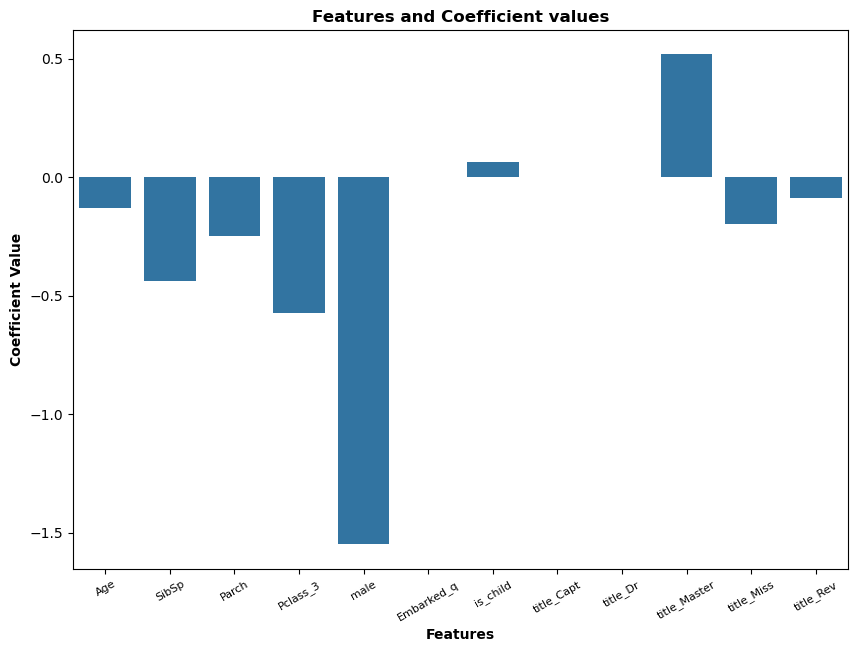

In [52]:
# Visualising the coefficients
plt.figure(figsize=(10,7))
sns.barplot(x = coefs.Feature, y = coefs.Coef)
plt.title('Features and Coefficient values', weight='bold')
plt.xlabel('Features', weight='bold')
plt.xticks(rotation=30, size=8)
plt.ylabel('Coefficient Value', weight='bold')
plt.savefig('log_reg_coefficients.png')
plt.show()

# Due to l1 penalty some coefficients have been reduced to 0

# Removing 0 coefficients

In [53]:
# Getting the coefficients for the tuned model
coefficients = tuned_model.coef_[0] 

# Finding the features with coefficients that are 0
non_zero_indices = np.where(coefficients != 0)[0]

# Removing any coeffs that are 0 from the x_train and x_test data
x_train_scaled_2 = x_train_scaled_2[:, non_zero_indices]
x_test_scaled_2 = x_test_scaled_2[:, non_zero_indices]

In [54]:
# Creating a log reg model to check that the score is still the same after removing cofficients with zero
final_model = LogisticRegression(penalty=grid_model.best_params_['penalty'], 
                                 C=grid_model.best_params_['C'], 
                                 solver=grid_model.best_params_['solver'], 
                                 random_state=1, n_jobs=-1)

# Fitting the model with the training data after removing zero cofficients
final_model.fit(x_train_scaled_2, y_train_res)

LogisticRegression(C=0.11497569953977356, n_jobs=-1, penalty='l1',
                   random_state=1, solver='liblinear')

In [55]:
# Checking the scores for the training and testing sets are the same as the tuned model
print('Train Score')
print(final_model.score(x_train_scaled_2, y_train_res))
print('Test Score')
print(final_model.score(x_test_scaled_2, y_test))

Train Score
0.828735632183908
Test Score
0.8971428571428571


# Roc Auc Curve & Thresholds

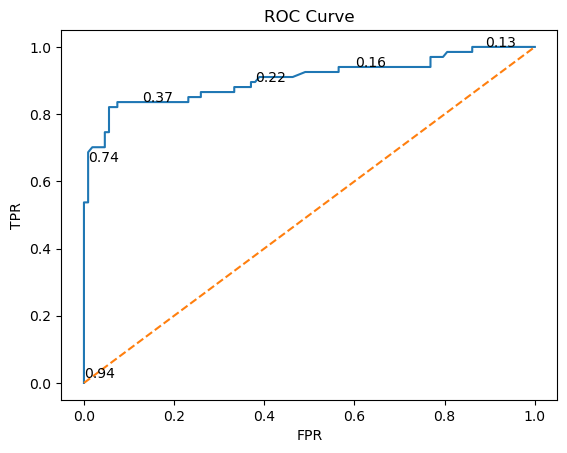

In [56]:
# Getting the probabilities of each outcome for the test set from the final model
y_pred_prob_test = final_model.predict_proba(x_test_scaled_2)

# Getting the true positive rate and false postive rate from the testing set
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob_test[:,1])

# Visualising the fpr and tpr 
plt.plot(fpr, tpr)
idx = list(range(len(threshold)))[1::10]
for i in idx:
    plt.text(fpr[i], tpr[i], threshold[i].round(2))
    
clf = DummyClassifier(strategy='most_frequent', random_state=0)
clf.fit(x_train_scaled_2, y_train_res)
roc_auc = roc_auc_score(y_test, clf.predict_proba(x_test_scaled_2)[:,1])

clf_fpr, clf_tpr, clf_threshold = roc_curve(y_test, clf.predict_proba(x_test_scaled_2)[:,1])
plt.plot(clf_fpr, clf_tpr, linestyle='--')

plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.savefig('log_reg_roc_curve.png')
plt.show()

In [57]:
# Finding the roc auc score
roc_auc_score_ = roc_auc_score(y_test, y_pred_prob_test[:,1])
roc_auc_score_

0.904228855721393

In [58]:
# Finding the best threshold youlden stat, highest tpr
j_scores = tpr - fpr

# Youlden's J statistic
youlden_threshold = threshold[np.argmax(j_scores)]
print('Optimal threshold ' + str(youlden_threshold))

Optimal threshold 0.5265794115226041


In [59]:
# Creating a confusion matrix with youlden threshold
y_pred_youlden = (y_pred_prob_test[:,1] >= youlden_threshold)*1.0
cm_youlden = confusion_matrix(y_test, y_pred_youlden)
print(cm_youlden)

[[102   6]
 [ 12  55]]


In [60]:
# Getting the accuracy score at youlden threshold
accuracy_youlden = accuracy_score(y_test, y_pred_youlden)
print('Accuracy score is ' + str(accuracy_youlden))

Accuracy score is 0.8971428571428571


# Learning Curve

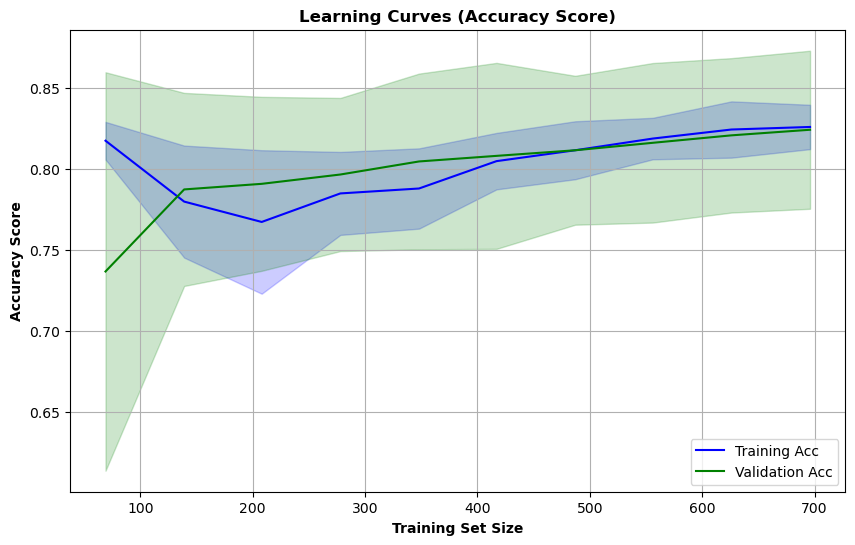

In [61]:
# Getting the learning curve data for the model
train_sizes, train_scores, val_scores = learning_curve(final_model, x_train_scaled_2, y_train_res, cv=5, scoring='accuracy', 
                                                       train_sizes=np.linspace(0.1, 1.0, 10), random_state=1, n_jobs=-1)

# Calculate the mean and std for the training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Visualising the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Acc', color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation Acc', color='green')

# Filling below and above the mean by 1 std for the training and validation sets
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, color='green', alpha=0.2)

plt.title('Learning Curves (Accuracy Score)', weight='bold')
plt.xlabel('Training Set Size', weight='bold')
plt.ylabel('Accuracy Score', weight='bold')
plt.legend(loc='best')
plt.grid(True)
plt.savefig('log_reg_learning_curve.png')
plt.show()

# Making Predictions

In [62]:
# Entering values including zero coefficient features so I can still use the standard scaler used during model training

# 'Age', 'SibSp', 'Parch', 'Pclass_3', 'male', 'Embarked_q', 'is_child', 'title_Capt', 'title_Dr', 'title_Master',
# 'title_Miss', 'title_Rev'

person_1 = np.array([25.0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
person_2 = np.array([50.0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0])
person_3 = np.array([20.0, 2, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0])
person_4 = np.array([55.0, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0])

# Adding all the predictions into the same variable
titanic_pred = np.stack((person_1, person_2, person_3, person_4))

In [63]:
# Scaling the predictions
titanic_pred = scaler_2.transform(titanic_pred)

In [64]:
# Removing the features/coefficients that were 0 during training
titanic_pred = titanic_pred[:, non_zero_indices]

In [65]:
# Using the tuned model to get the predictions
print(final_model.predict(titanic_pred))

# Using the model to get the probabilities for each outcome
print(final_model.predict_proba(titanic_pred))

[0 0 1 1]
[[0.61113384 0.38886616]
 [0.81602894 0.18397106]
 [0.01794104 0.98205896]
 [0.47780017 0.52219983]]
